In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
np.random.seed(123)

In [8]:
train = pd.read_json('train.json')
train.set_index('id', inplace=True)

In [9]:
train.head()

,cuisine,ingredients
id,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,indian,"[water, vegetable oil, wheat, salt]"
13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Data columns (total 2 columns):
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: object(2)
memory usage: 2.2+ MB


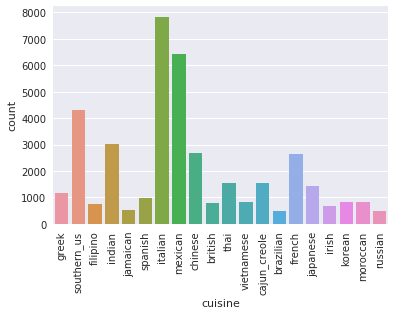

In [19]:
sns.countplot(train.cuisine, orient='h');
plt.xticks(rotation=90);

### The labels are very unballanced !

In [27]:
train['ingredients'] = train['ingredients'].apply(lambda ingredients_list: ' '.join(ingredients_list)) #ingredients of two words can get lost
train.head()

,cuisine,ingredients
id,,
10259,greek,romaine lettuce black olives grape tomatoes ga...
25693,southern_us,plain flour ground pepper salt tomatoes ground...
20130,filipino,eggs pepper salt mayonaise cooking oil green c...
22213,indian,water vegetable oil wheat salt
13162,indian,black pepper shallots cornflour cayenne pepper...


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import datetime
import os

In [39]:
import multiprocessing
def model_run(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) 
    test_pred = model.predict(X_test)

    train_precision = metrics.precision_score(y_train, train_pred, average='weighted')
    test_precision = metrics.precision_score(y_test, test_pred, average='weighted')
    
    train_recall = metrics.recall_score(y_train, train_pred, average='weighted')
    test_recall = metrics.recall_score(y_test, test_pred, average='weighted')

    return train_precision, test_precision, train_recall, test_recall

def test_on_train(model, X, y):
    input_to_multi = []
    start = datetime.datetime.now()
    for train_index, test_index in RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=222).split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        input_to_multi.append([model, X_train, X_test, y_train, y_test])

    with multiprocessing.Pool() as p:
        KFold_results = p.starmap(model_run, input_to_multi)


    print(datetime.datetime.now() - start)
    return pd.DataFrame(KFold_results,
                        columns=['train_precision', 'test_precision', 'train_recall', 'test_recall']).mean(axis=0)

In [58]:
X = train.ingredients
y = train.cuisine

model = Pipeline([
#     ('bag_of_words', CountVectorizer()),
    ('tfidf', TfidfVectorizer()),
#     ('logreg', LogisticRegression(penalty='l2',C=1.0, class_weight='balanced',
#                                   n_jobs=1, solver='liblinear', max_iter=100, multi_class='ovr'))
    ('svm', SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, class_weight='balanced'))
])

In [ ]:
test_on_train(model, X, y)

In [ ]:
train_precision    0.850560
test_precision     0.783391
train_recall       0.849839
test_recall        0.785727